MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time: 1.20 seconds


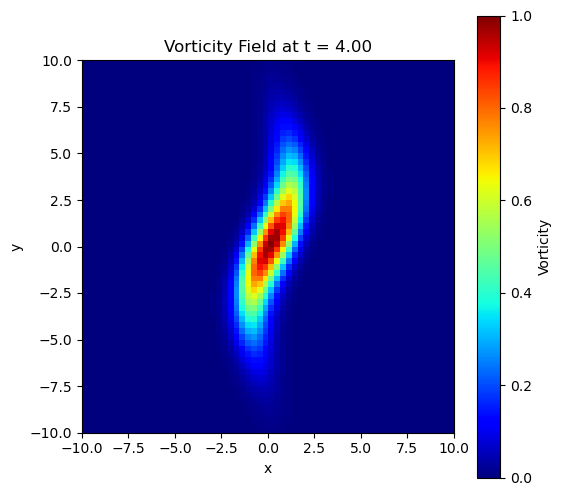

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
import time


# Parameters
dx = 0.3125  # (x, y in [-10, 10], 64 points)
m = 64    # N value in x and y directions
n = m * m  # total size of matrix

##### A matrix #####
e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwrite every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = spdiags(diagonals, offsets, n, n).toarray()
matA = matA / (dx**2)

##### B matrix #####

# Initialize vectors
e1 = np.ones((n, 1))   # vector of ones

# Construct the central difference matrix B (derivative with respect to x)
diagonals = [e1.flatten(), -e1.flatten(), e1.flatten(), -e1.flatten()]
offsets = [-(n-m), -m, m, (n-m)]

# Construct the sparse matrix
matB = spdiags(diagonals, offsets, n, n).toarray()
matB = matB / (2 * dx)  # Second-order central difference

##### C matrix #####

e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwrite every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e5.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets = [-m+1, -1, 1, m-1]

matC = spdiags(diagonals, offsets, n, n).toarray()
matC = matC / (2 * dx)


######## Part A ################

# Parameters
tspan = np.arange(0, 4.5, 0.5)  # Time span from 0 to 4 with step size of 0.5
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx//2), np.arange(-nx//2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny//2), np.arange(-ny//2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system
def spc_rhs(t, w, K, nu):
    wt = fft2(w.reshape((nx, ny)))
    
    # Compute psi
    psi = np.real(ifft2(-wt / K))
    psi = psi.flatten()

    w = w.flatten()
    
    # Compute the right-hand side of the ODE
    rhs = (nu * np.dot(matA, w) - np.dot(matB, psi) * np.dot(matC, w) + np.dot(matC, psi) * np.dot(matB, w))
    
    return rhs

# Initial condition:
w0 = np.exp(-X**2 - Y**2 / 20).flatten() 

# start timing stuff
start_time = time.time() # Record the start time

# Solve the ODE using solve_ivp
wtsol = solve_ivp(spc_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu))

# end time
end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Store the solution in variable A1
A1 = wtsol.y

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(A1[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(A1[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=A1.shape[1], blit=True)
anim.save('./vorticity_evolution.gif', writer='imagemagick', fps=2)


Elapsed time: 61.35 seconds


MovieWriter imagemagick unavailable; using Pillow instead.


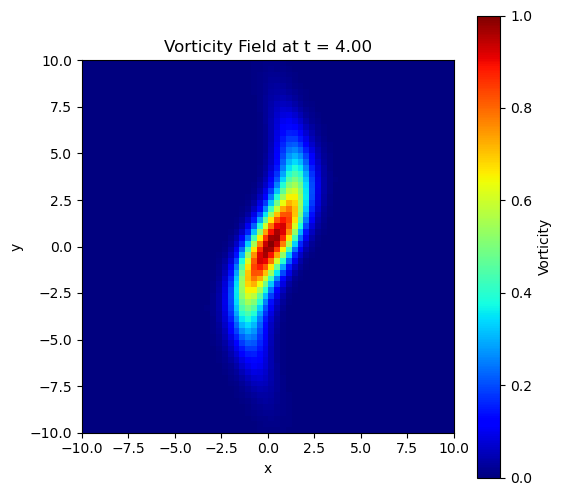

In [14]:
### Part B ###
from scipy.linalg import solve


matA[0,0] = 2/(dx**2)


## A/b


def backslash_rhs(t, w, K, nu):
    
    psi = solve(matA, w)

    psi = psi.flatten()

    w = w.flatten()
    
    # Compute the right-hand side of the ODE
    rhs = (nu * np.dot(matA, w) - np.dot(matB, psi) * np.dot(matC, w) + np.dot(matC, psi) * np.dot(matB, w))
    
    return rhs


start_time = time.time() # Record the start time

w0 = np.exp(-X**2 - Y**2 / 20).flatten() 

A2 = solve_ivp(backslash_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu)).y

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(A2[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(A2[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=A2.shape[1], blit=True)
anim.save('./vorticity_evolution_backslash.gif', writer='imagemagick', fps=2)


MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time: 2.76 seconds


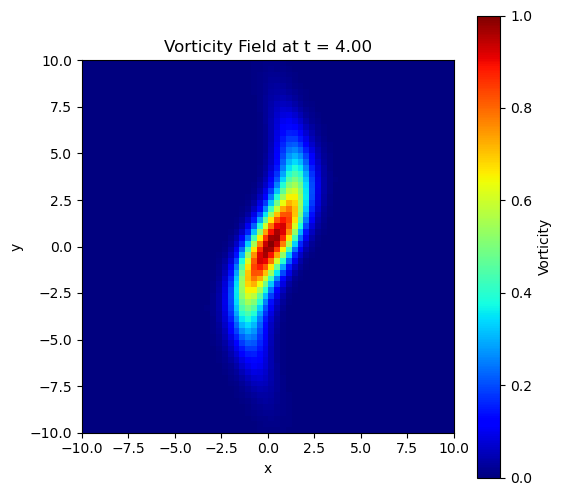

In [15]:
### LU ###
from scipy.linalg import lu, solve_triangular



P, L, U = lu(matA)

def LU_rhs(t, w, K, nu, P, L, U):
    
    Pb = np.dot(P, w)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)

    psi = psi.flatten()

    w = w.flatten()
    
    # Compute the right-hand side of the ODE
    rhs = (nu * np.dot(matA, w) - np.dot(matB, psi) * np.dot(matC, w) + np.dot(matC, psi) * np.dot(matB, w))
    
    return rhs

start_time = time.time() # Record the start time

w0 = np.exp(-X**2 - Y**2 / 20).flatten() 

A3 = solve_ivp(LU_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu, P, L, U)).y

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(A3[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(A3[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=A3.shape[1], blit=True)
anim.save('./vorticity_evolution_LU.gif', writer='imagemagick', fps=2)


C:\Users\kaipo\AppData\Local\Temp\ipykernel_31164\3638924798.py:15: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  psi, exitcode = gmres(A, w, tol = 1e-4, callback = gm_callback)
C:\Users\kaipo\AppData\Local\Temp\ipykernel_31164\3638924798.py:15: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  psi, exitcode = gmres(A, w, tol = 1e-4, callback = gm_callback)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Elapsed time: 68.09 seconds
residual stuff
residual array:  [0.7960252455658321, 0.6943828551240198, 0.6321250625556447, 0.6023150001667371, 0.5620999524452582, 0.5353266281075765, 0.5099529123085393, 0.48902641080126447, 0.46884922598599843, 0.4522780311049873, 0.4356479955803297, 0.4217491606482589, 0.40808196880263325, 0.39598415357172745, 0.3846433625599492, 0.3740734017838394, 0.3644146688371886, 0.35529624117584147, 0.3468881930889846, 0.3390608384922902, 0.3352512322781087, 0.33142835616094835, 0.3275507120126789, 0.3237073662487939, 0.3198510021678638, 0.3160322194657489, 0.31232016303736154, 0.3085532482635153, 0.30493017345518625, 0.3012197379341834, 0.2976345030323606, 0.29435924401667096, 0.29136771327174843, 0.28913079367616606, 0.28786790248856275, 0.28782919250723765, 0.28708784182844793, 0.2859773043041876, 0.2845908442747247, 0.2825297396246135, 0.2815557675445924, 0.28070223772868014, 0.28005800142470133, 0.279492826

MovieWriter imagemagick unavailable; using Pillow instead.


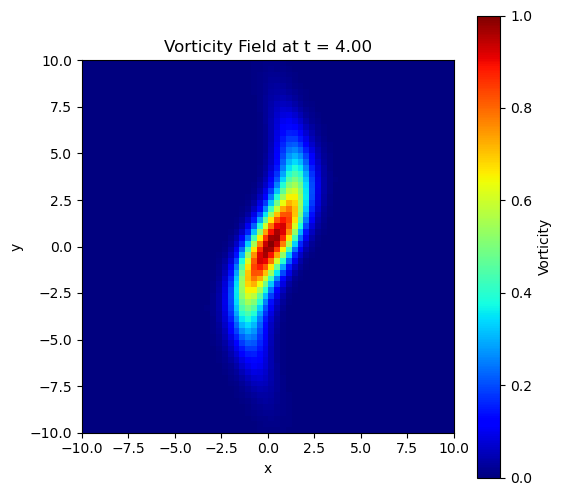

In [16]:
### GMRES ####
from scipy.sparse.linalg import gmres
from scipy.sparse import csr_matrix

psi0 = np.zeros(4096)

Asparse = csr_matrix(matA)

residuals_gm = []
def gm_callback(residual_norm):
    residuals_gm.append(residual_norm)

def GMRES_rhs(t, w, K, nu, A, psi0):

    psi, exitcode = gmres(A, w, tol = 1e-4, callback = gm_callback)
    psi0 = psi

    print(exitcode)
    
    psi = psi.flatten()

    w = w.flatten()
    
    # Compute the right-hand side of the ODE
    rhs = (nu * np.dot(matA, w) - np.dot(matB, psi) * np.dot(matC, w) + np.dot(matC, psi) * np.dot(matB, w))
    
    return rhs


start_time = time.time() # Record the start time

w0 = np.exp(-X**2 - Y**2 / 20).flatten() 

A4 = solve_ivp(GMRES_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu, Asparse, psi0)).y

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

print("residual stuff")
print("residual array: ", residuals_gm)
print("length of residual array: ", len(residuals_gm))

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(A4[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(A4[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=A4.shape[1], blit=True)
anim.save('./vorticity_evolution_GMRES.gif', writer='imagemagick', fps=2)






C:\Users\kaipo\AppData\Local\Temp\ipykernel_31164\283586034.py:15: DeprecationWarning: 'scipy.sparse.linalg.bicgstab' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  psi, exitcode = bicgstab(A, w, tol = 1e-4, callback = bic_callback)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Elapsed time: 3.95 seconds
residual stuff
residual array:  

MovieWriter imagemagick unavailable; using Pillow instead.


[array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2.33792355, -1.16923653, -2.76051873, ..., -3.84170118,
       -3.08624042, -2.1271725 ]), array([ 2

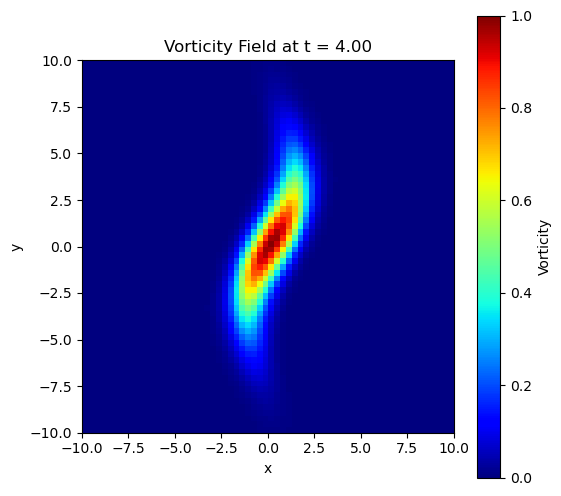

In [17]:
### BICGSTAB ####
from scipy.sparse.linalg import bicgstab

psi0 = np.zeros(4096)

Asparse = csr_matrix(matA)

residuals_bic = []
def bic_callback(residual_norm):
    residuals_bic.append(residual_norm)


def BICGSTAB_rhs(t, w, K, nu, A, psi0):

    psi, exitcode = bicgstab(A, w, tol = 1e-4, callback = bic_callback)
    psi0 = psi

    print(exitcode)
    
    psi = psi.flatten()

    w = w.flatten()
    
    # Compute the right-hand side of the ODE
    rhs = (nu * np.dot(matA, w) - np.dot(matB, psi) * np.dot(matC, w) + np.dot(matC, psi) * np.dot(matB, w))
    
    return rhs

start_time = time.time() # Record the start time

w0 = np.exp(-X**2 - Y**2 / 20).flatten() 

A5 = solve_ivp(BICGSTAB_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu, Asparse, psi0)).y

end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

print("residual stuff")
print("residual array: ", residuals_bic)
print("length of residual array: ", len(residuals_bic))

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(A5[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(A5[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=A5.shape[1], blit=True)
anim.save('./vorticity_evolution_BICGSTAB.gif', writer='imagemagick', fps=2)



MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


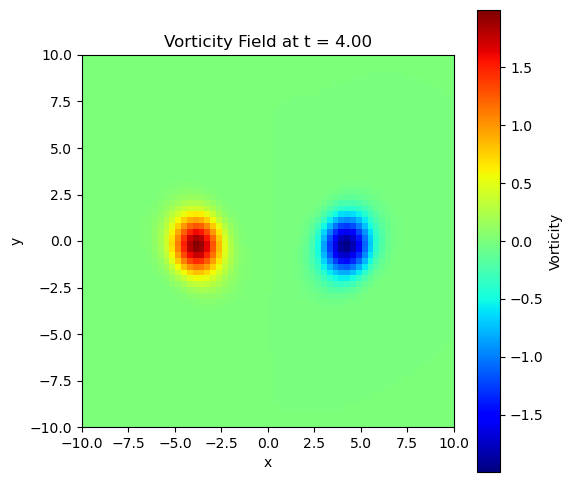

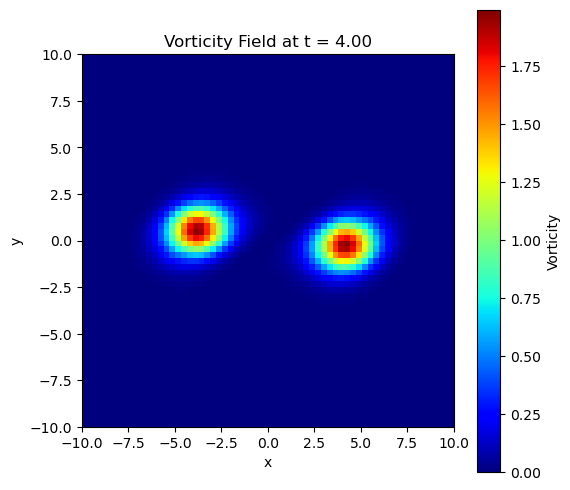

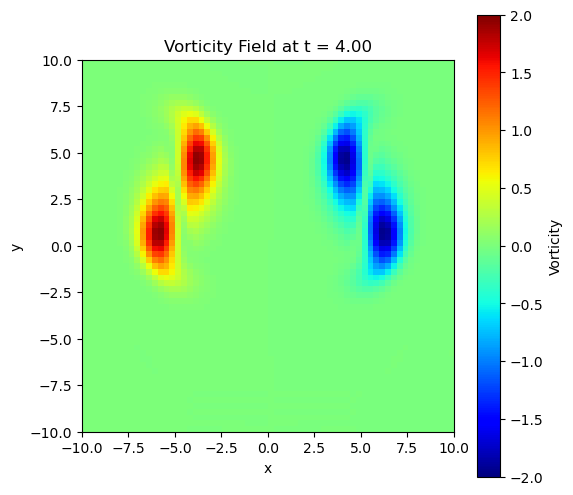

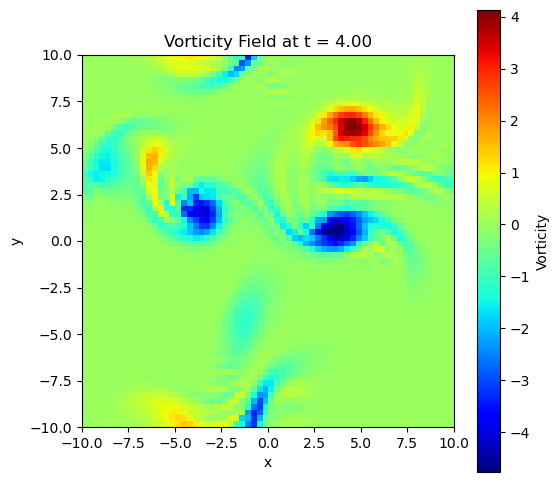

In [18]:
#### Part C ####
# Initial condition functions

def initial_condition_1(X, Y, Lx, Ly):
    # Parameters for Gaussian vortices
    sigma = 1.0  # Standard deviation of the Gaussian
    vortex_strength = 2.0  # Increased strength for more "violent" movement

    # Create two vortices at different positions
    x1, y1 = -4, 0  # Position of the positive vortex
    x2, y2 = 4, 0   # Position of the negative vortex
    
    # Positive vortex
    w1 = vortex_strength * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2))
    
    # Negative vortex
    w2 = -vortex_strength * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2))

    # Superposition of both vortices
    w0 = w1 + w2
    return w0

def initial_condition_2(X, Y, Lx, Ly):
    # Parameters for Gaussian vortices
    sigma = 1.0  # Standard deviation of the Gaussian
    vortex_strength = 2.0  # Increased strength for more "violent" movement

    # Create two vortices at different positions
    x1, y1 = -4, 0  # Position of the first vortex
    x2, y2 = 4, 0   # Position of the second vortex
    
    # Both vortices with positive charge
    w1 = vortex_strength * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2))
    w2 = vortex_strength * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2))

    # Superposition of both vortices
    w0 = w1 + w2
    return w0

def initial_condition_3(X, Y, Lx, Ly):
    # Parameters for Gaussian vortices
    sigma = 1.0  # Standard deviation of the Gaussian
    vortex_strength = 2.0  # Increased strength for more "violent" movement

    # Create four vortices
    x1, y1 = -5, 0  # Position of the first positive vortex
    x2, y2 = 5, 0   # Position of the first negative vortex
    x3, y3 = -5, 5  # Position of the second positive vortex
    x4, y4 = 5, 5   # Position of the second negative vortex
    
    # Positive vortices
    w1 = vortex_strength * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2))
    w3 = vortex_strength * np.exp(-((X - x3)**2 + (Y - y3)**2) / (2 * sigma**2))

    # Negative vortices
    w2 = -vortex_strength * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2))
    w4 = -vortex_strength * np.exp(-((X - x4)**2 + (Y - y4)**2) / (2 * sigma**2))

    # Superposition of all four vortices
    w0 = w1 + w2 + w3 + w4
    return w0

def initial_condition_4(X, Y, Lx, Ly, num_vortices=10):
    # Parameters for Gaussian vortices
    sigma = 1.0  # Standard deviation of the Gaussian (base shape)
    
    # Randomly generate vortex parameters
    np.random.seed(42)  # Set random seed for reproducibility
    positions = np.random.uniform(-Lx/2, Lx/2, (num_vortices, 2))  # Random positions
    charges = np.random.choice([1, -1], num_vortices)  # Random charge (+1 or -1)
    strengths = np.random.uniform(1.0, 5.0, num_vortices)  # Increased strength range
    angles = np.random.uniform(0, 2 * np.pi, num_vortices)  # Random orientation angles for ellipticity
    elongations = np.random.uniform(0.5, 2.0, num_vortices)  # Random ellipticity (1 is a circle, > 1 is elongated)

    w0 = np.zeros_like(X)
    
    for i in range(num_vortices):
        # Random position, charge, and strength
        x, y = positions[i]
        charge = charges[i]  # +1 or -1
        strength = strengths[i]  # Amplitude of the vortex
        
        # Random ellipticity and orientation
        angle = angles[i]
        elongation = elongations[i]

        # Elliptical Gaussian parameters (variance scaling)
        sigma_x = sigma * elongation  # Elliptical variance in x-direction
        sigma_y = sigma / elongation  # Elliptical variance in y-direction

        # Generate elliptical Gaussian vortex
        X_rot, Y_rot = rotate_coords(X, Y, angle)  # Rotate coordinates based on the angle

        # Vortex strength multiplied by the Gaussian function (ellipse scaling)
        vortex = charge * strength * np.exp(-((X_rot - x)**2 / (2 * sigma_x**2) + (Y_rot - y)**2 / (2 * sigma_y**2)))
        
        # Superpose the vortex to the total field
        w0 += vortex

    return w0

def rotate_coords(X, Y, angle):
    """ Rotate coordinates (X, Y) by the given angle for ellipticity """
    X_rot = X * np.cos(angle) + Y * np.sin(angle)
    Y_rot = -X * np.sin(angle) + Y * np.cos(angle)
    return X_rot, Y_rot

################################################

# Use a chosen initial condition
w0 = initial_condition_1(X, Y, Lx, Ly).flatten()  # Replace w0 with the desired initial condition

# Solve the ODE using solve_ivp
wtsol = solve_ivp(spc_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu))
IC1 = wtsol.y

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(IC1[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(IC1[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=IC1.shape[1], blit=True)
anim.save('./vorticity_evolution_opposite_charge.gif', writer='imagemagick', fps=2)

###########################################

# Use a chosen initial condition
w0 = initial_condition_2(X, Y, Lx, Ly).flatten()  # Replace w0 with the desired initial condition

# Solve the ODE using solve_ivp
wtsol = solve_ivp(spc_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu))
IC2 = wtsol.y

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(IC2[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(IC2[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=IC2.shape[1], blit=True)
anim.save('./vorticity_evolution_same_charge.gif', writer='imagemagick', fps=2)


###########################################

# Use a chosen initial condition
w0 = initial_condition_3(X, Y, Lx, Ly).flatten()  # Replace w0 with the desired initial condition

# Solve the ODE using solve_ivp
wtsol = solve_ivp(spc_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu))
IC3 = wtsol.y

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(IC3[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(IC3[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=IC3.shape[1], blit=True)
anim.save('./vorticity_evolution_opposite_collide.gif', writer='imagemagick', fps=2)


###########################################

# Use a chosen initial condition
w0 = initial_condition_4(X, Y, Lx, Ly).flatten()  # Replace w0 with the desired initial condition

# Solve the ODE using solve_ivp
wtsol = solve_ivp(spc_rhs, (tspan[0], tspan[-1]), w0, method = 'RK45', t_eval=tspan, args=(K, nu))
IC4 = wtsol.y

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(IC4[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet', origin = 'lower')
fig.colorbar(cax, ax=ax, label = 'Vorticity')
ax.set_title('Vorticity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')
def update(frame):
    ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
    cax.set_data(IC4[:, frame].reshape((nx, ny)))
    return cax,
anim = FuncAnimation(fig, update, frames=IC4.shape[1], blit=True)
anim.save('./vorticity_evolution_random.gif', writer='imagemagick', fps=2)